#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/KTAIVLE/6차 미니프로젝트/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout, GlobalMaxPool1D
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [6]:
# oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
# orders = pd.read_csv(path + 'train/orders_train.csv')
# sales = pd.read_csv(path + 'train/sales_train.csv')
# products = pd.read_csv(path + 'train/products.csv')
# stores = pd.read_csv(path + 'train/stores.csv')

# sales['Date'] = pd.to_datetime(sales['Date'] )
# oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
# orders['Date'] = pd.to_datetime(orders['Date'] )
df = pd.read_csv(path + 'master_df.csv')
df_test = pd.read_csv(path + 'master_test.csv', encoding='cp949')

In [7]:
df['Date'] = pd.to_datetime(df['Date'] )
df_test['Date'] = pd.to_datetime(df_test['Date'] )

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617994 entries, 0 to 617993
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Unnamed: 0                 617994 non-null  int64         
 1   Date                       617994 non-null  datetime64[ns]
 2   Store_ID                   617994 non-null  int64         
 3   Qty                        617994 non-null  float64       
 4   Product_ID                 617994 non-null  int64         
 5   WTI_Price                  617994 non-null  float64       
 6   CustomerCount              617994 non-null  int64         
 7   Product_Code               617994 non-null  object        
 8   SubCategory                617994 non-null  object        
 9   Category                   617994 non-null  object        
 10  LeadTime                   617994 non-null  int64         
 11  Price                      617994 non-null  int64   

In [9]:
subCategory_dummies = pd.get_dummies(df['SubCategory'], prefix='SubCategory')
category_dummies = pd.get_dummies(df['Category'], prefix='Category')
city_dummies = pd.get_dummies(df['City'], prefix='City')
state_dummies = pd.get_dummies(df['State'], prefix='State')

df = pd.concat([df, subCategory_dummies, category_dummies, city_dummies, state_dummies], axis=1)
df.drop(['SubCategory', 'Category', 'City', 'State'], axis=1, inplace=True)

In [10]:
subCategory_dummies = pd.get_dummies(df_test['SubCategory'], prefix='SubCategory')
category_dummies = pd.get_dummies(df_test['Category'], prefix='Category')
city_dummies = pd.get_dummies(df_test['City'], prefix='City')
state_dummies = pd.get_dummies(df_test['State'], prefix='State')

df_test = pd.concat([df_test, subCategory_dummies, category_dummies, city_dummies, state_dummies], axis=1)
df_test.drop(['SubCategory', 'Category', 'City', 'State'], axis=1, inplace=True)

In [11]:
df.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)
df.drop(columns='Unnamed: 0', inplace=True)
df_test.drop(columns='Unnamed: 0', inplace=True)
df.drop(columns='Product_Code', inplace=True)
df_test.drop(columns='Product_Code', inplace=True)

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [15]:
temp = df.loc[(df['Store_ID'] == 44) & (df['Product_ID'].isin([3, 12, 42]))]

## **(1) 상품 : 3 - Beverage**

In [16]:
temp3 = temp.loc[temp['Product_ID'] == 3]
temp3

,Store_ID,Qty,Product_ID,WTI_Price,CustomerCount,LeadTime,Price,Store_Type,종가,시가,...,State_Massachusetts,State_Minnesota,State_New York,State_North Carolina,State_Ohio,State_Oklahoma,State_Pennsylvania,State_Tennessee,State_Virginia,State_Washington
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,44,9853.0,3,95.14,4422,2,8,1,4143.07,4160.03,...,False,True,False,False,False,False,False,False,False,False
2014-01-03,44,8647.0,3,93.66,4167,2,8,1,4131.91,4148.56,...,False,True,False,False,False,False,False,False,False,False
2014-01-06,44,7900.0,3,93.12,3917,2,8,1,4113.68,4137.03,...,False,True,False,False,False,False,False,False,False,False
2014-01-07,44,7188.0,3,93.31,3663,2,8,1,4153.18,4128.57,...,False,True,False,False,False,False,False,False,False,False
2014-01-08,44,8800.0,3,91.90,4254,2,8,1,4165.61,4154.28,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-22,44,7856.0,3,53.61,3834,2,8,1,5860.63,5857.56,...,False,True,False,False,False,False,False,False,False,False
2017-02-23,44,8018.0,3,54.48,3955,2,8,1,5835.51,5866.82,...,False,True,False,False,False,False,False,False,False,False
2017-02-24,44,10208.0,3,53.99,4549,2,8,1,5845.31,5802.33,...,False,True,False,False,False,False,False,False,False,False


## **(2) 상품 : 12 - Milk**

In [17]:
temp12 = temp.loc[temp['Product_ID'] == 12]
temp12

,Store_ID,Qty,Product_ID,WTI_Price,CustomerCount,LeadTime,Price,Store_Type,종가,시가,...,State_Massachusetts,State_Minnesota,State_New York,State_North Carolina,State_Ohio,State_Oklahoma,State_Pennsylvania,State_Tennessee,State_Virginia,State_Washington
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,44,9647.0,12,95.14,4422,2,6,1,4143.07,4160.03,...,False,True,False,False,False,False,False,False,False,False
2014-01-03,44,8879.0,12,93.66,4167,2,6,1,4131.91,4148.56,...,False,True,False,False,False,False,False,False,False,False
2014-01-06,44,7614.0,12,93.12,3917,2,6,1,4113.68,4137.03,...,False,True,False,False,False,False,False,False,False,False
2014-01-07,44,7124.0,12,93.31,3663,2,6,1,4153.18,4128.57,...,False,True,False,False,False,False,False,False,False,False
2014-01-08,44,8683.0,12,91.90,4254,2,6,1,4165.61,4154.28,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-22,44,8931.0,12,53.61,3834,2,6,1,5860.63,5857.56,...,False,True,False,False,False,False,False,False,False,False
2017-02-23,44,8643.0,12,54.48,3955,2,6,1,5835.51,5866.82,...,False,True,False,False,False,False,False,False,False,False
2017-02-24,44,10630.0,12,53.99,4549,2,6,1,5845.31,5802.33,...,False,True,False,False,False,False,False,False,False,False


## **(3) 상품 : 42 - Agricultural products**

In [18]:
temp42 = temp.loc[temp['Product_ID'] == 12]
temp42

,Store_ID,Qty,Product_ID,WTI_Price,CustomerCount,LeadTime,Price,Store_Type,종가,시가,...,State_Massachusetts,State_Minnesota,State_New York,State_North Carolina,State_Ohio,State_Oklahoma,State_Pennsylvania,State_Tennessee,State_Virginia,State_Washington
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,44,9647.0,12,95.14,4422,2,6,1,4143.07,4160.03,...,False,True,False,False,False,False,False,False,False,False
2014-01-03,44,8879.0,12,93.66,4167,2,6,1,4131.91,4148.56,...,False,True,False,False,False,False,False,False,False,False
2014-01-06,44,7614.0,12,93.12,3917,2,6,1,4113.68,4137.03,...,False,True,False,False,False,False,False,False,False,False
2014-01-07,44,7124.0,12,93.31,3663,2,6,1,4153.18,4128.57,...,False,True,False,False,False,False,False,False,False,False
2014-01-08,44,8683.0,12,91.90,4254,2,6,1,4165.61,4154.28,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-22,44,8931.0,12,53.61,3834,2,6,1,5860.63,5857.56,...,False,True,False,False,False,False,False,False,False,False
2017-02-23,44,8643.0,12,54.48,3955,2,6,1,5835.51,5866.82,...,False,True,False,False,False,False,False,False,False,False
2017-02-24,44,10630.0,12,53.99,4549,2,6,1,5845.31,5802.33,...,False,True,False,False,False,False,False,False,False,False


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [19]:
# 해당 제품 ID와 스토어 ID 44에 대한 데이터 필터링
filtered_df = df[(df['Store_ID'] == 44) & (df['Product_ID'] == 3)]

# 'Qty'를 제외한 나머지 컬럼을 특성으로 사용
X = filtered_df.drop(['Qty'], axis=1).values
Y = filtered_df['Qty'].values

# 데이터 정규화
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X = scaler_X.fit_transform(X)
Y = scaler_Y.fit_transform(Y.reshape(-1,1)).flatten()

x_train_3, x_val_3, y_train_3, y_val_3 = train_test_split(X, Y, test_size = 60, shuffle = False)

### **2) 모델링**

In [20]:
model = Sequential()
model.add( Dense(64, input_shape = (x_train_3.shape[1],), activation = 'relu'))
model.add( Dense(32, activation = 'relu'))
model.add( Dropout(0.2))
model.add( Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(x_train_3, y_train_3, validation_data = (x_val_3, y_val_3), verbose = 1, epochs = 60).history

Epoch 1/60
24/24 [==============================] - 5s 16ms/step - loss: 0.0232 - val_loss: 0.0236
Epoch 2/60
24/24 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0324
Epoch 3/60
24/24 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0321
Epoch 4/60
24/24 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0238
Epoch 5/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 0.0220
Epoch 6/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0199
Epoch 7/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0238
Epoch 8/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0182
Epoch 9/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0157
Epoch 10/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0158
Epoch 11/60
24/24 

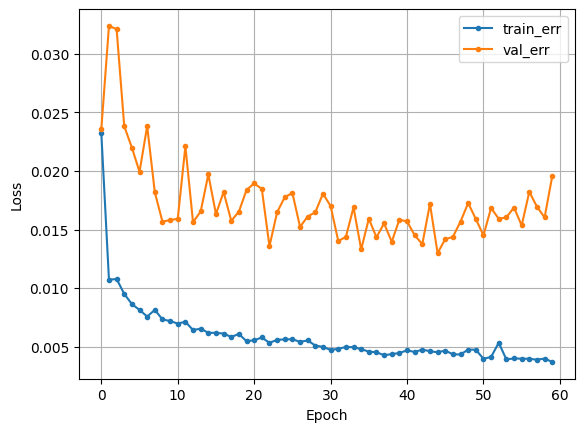

In [21]:
dl_history_plot(history)

In [22]:
# 예측 및 예측 값 역정규화
prediction_scaled = model.predict(x_val_3)
prediction = scaler_Y.inverse_transform(prediction_scaled)

# 실제 값과 예측 값의 RMSE, MAE, MAPE, R², MSE 계산 및 출력
Y_test_inv = scaler_Y.inverse_transform(y_val_3.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(Y_test_inv, prediction))
mae = mean_absolute_error(Y_test_inv, prediction)
mape = mean_absolute_percentage_error(Y_test_inv, prediction)
r2 = r2_score(Y_test_inv, prediction)
mse = mean_squared_error(Y_test_inv, prediction)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'R²: {r2}')
print(f'MSE: {mse}')

2/2 [==============================] - 0s 7ms/step
RMSE: 2784.5347796547353
MAE: 1883.815185546875
MAPE: 0.18844197051568298
R²: -0.6703507684885153
MSE: 7753633.939106846


## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [23]:
# 해당 제품 ID와 스토어 ID 44에 대한 데이터 필터링
filtered_df = df[(df['Store_ID'] == 44) & (df['Product_ID'] == 12)]

# 'Qty'를 제외한 나머지 컬럼을 특성으로 사용
X = filtered_df.drop(['Qty'], axis=1).values
Y = filtered_df['Qty'].values

# 데이터 정규화
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X = scaler_X.fit_transform(X)
Y = scaler_Y.fit_transform(Y.reshape(-1,1)).flatten()

x_train_12, x_val_12, y_train_12, y_val_12 = train_test_split(X, Y, test_size = 60, shuffle = False)

### **2) 모델링**

In [24]:
model = Sequential()
model.add( Dense(64, input_shape = (x_train_3.shape[1],), activation = 'relu'))
model.add( Dense(32, activation = 'relu'))
model.add( Dropout(0.2))
model.add( Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(x_train_12, y_train_12, validation_data = (x_val_12, y_val_12), verbose = 1, epochs = 60).history

Epoch 1/60
24/24 [==============================] - 1s 12ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 2/60
24/24 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0111
Epoch 3/60
24/24 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0096
Epoch 4/60
24/24 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 5/60
24/24 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0092
Epoch 6/60
24/24 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0083
Epoch 7/60
24/24 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0071
Epoch 8/60
24/24 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0067
Epoch 9/60
24/24 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0066
Epoch 10/60
24/24 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0065
Epoch 11/60
24/24 

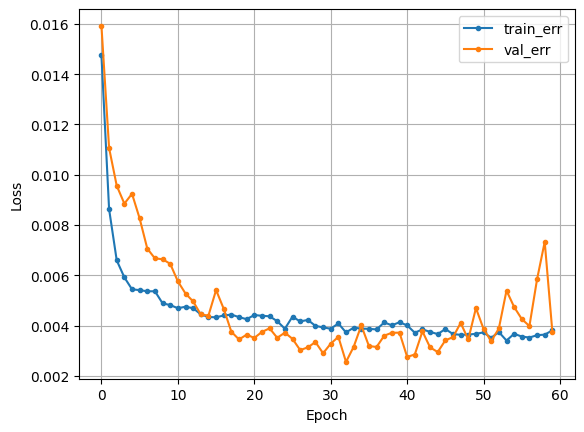

In [25]:
dl_history_plot(history)

In [26]:
# 예측 및 예측 값 역정규화
prediction_scaled = model.predict(x_val_12)
prediction = scaler_Y.inverse_transform(prediction_scaled)

# 실제 값과 예측 값의 RMSE, MAE, MAPE, R², MSE 계산 및 출력
Y_test_inv = scaler_Y.inverse_transform(y_val_12.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(Y_test_inv, prediction))
mae = mean_absolute_error(Y_test_inv, prediction)
mape = mean_absolute_percentage_error(Y_test_inv, prediction)
r2 = r2_score(Y_test_inv, prediction)
mse = mean_squared_error(Y_test_inv, prediction)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'R²: {r2}')
print(f'MSE: {mse}')

2/2 [==============================] - 0s 4ms/step
RMSE: 2003.767678798683
MAE: 1704.2725748697917
MAPE: 0.16232098453943788
R²: 0.6022440356169843
MSE: 4015084.910598262


## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [27]:
# 해당 제품 ID와 스토어 ID 44에 대한 데이터 필터링
filtered_df = df[(df['Store_ID'] == 44) & (df['Product_ID'] == 42)]

# 'Qty'를 제외한 나머지 컬럼을 특성으로 사용
X = filtered_df.drop(['Qty'], axis=1).values
Y = filtered_df['Qty'].values

# 데이터 정규화
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X = scaler_X.fit_transform(X)
Y = scaler_Y.fit_transform(Y.reshape(-1,1)).flatten()

x_train_42, x_val_42, y_train_42, y_val_42 = train_test_split(X, Y, test_size = 60, shuffle = False)

### **2) 모델링**

In [28]:
model = Sequential()
model.add( Dense(64, input_shape = (x_train_3.shape[1],), activation = 'relu'))
model.add( Dense(32, activation = 'relu'))
model.add( Dropout(0.2))
model.add( Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(x_train_42, y_train_42, validation_data = (x_val_42, y_val_42), verbose = 1, epochs = 60).history

Epoch 1/60
24/24 [==============================] - 1s 9ms/step - loss: 0.0533 - val_loss: 0.0275
Epoch 2/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0313 - val_loss: 0.0469
Epoch 3/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0262 - val_loss: 0.0358
Epoch 4/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0216 - val_loss: 0.0248
Epoch 5/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0222 - val_loss: 0.0124
Epoch 6/60
24/24 [==============================] - 0s 3ms/step - loss: 0.0202 - val_loss: 0.0129
Epoch 7/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0195
Epoch 8/60
24/24 [==============================] - 0s 3ms/step - loss: 0.0172 - val_loss: 0.0247
Epoch 9/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0164 - val_loss: 0.0129
Epoch 10/60
24/24 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0158
Epoch 11/60
24/24 [

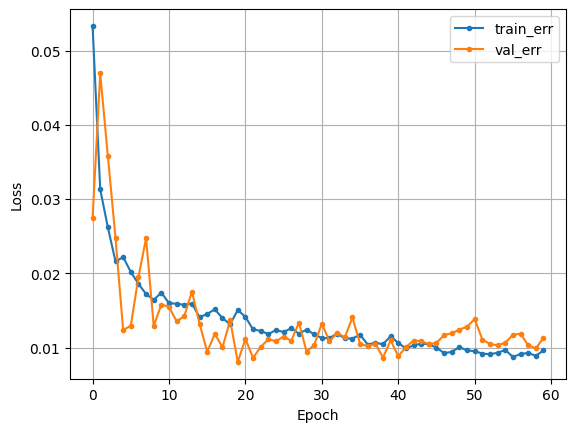

In [29]:
dl_history_plot(history)

In [30]:
# 예측 및 예측 값 역정규화
prediction_scaled = model.predict(x_val_42)
prediction = scaler_Y.inverse_transform(prediction_scaled)

# 실제 값과 예측 값의 RMSE, MAE, MAPE, R², MSE 계산 및 출력
Y_test_inv = scaler_Y.inverse_transform(y_val_42.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(Y_test_inv, prediction))
mae = mean_absolute_error(Y_test_inv, prediction)
mape = mean_absolute_percentage_error(Y_test_inv, prediction)
r2 = r2_score(Y_test_inv, prediction)
mse = mean_squared_error(Y_test_inv, prediction)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'R²: {r2}')
print(f'MSE: {mse}')

2/2 [==============================] - 0s 4ms/step
RMSE: 14.45711470194614
MAE: 11.949067560831706
MAPE: 0.1432824473125199
R²: -0.29667725788431
MSE: 209.00816550522723


# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 초기 모델링**

In [31]:
# 데이터 준비 함수
def prepare_data(df, product_id, look_back=2):
    # 해당 제품 ID와 스토어 ID 44에 대한 데이터 필터링
    filtered_df = df[(df['Store_ID'] == 44) & (df['Product_ID'] == product_id)]

    # 'Qty'를 제외한 나머지 컬럼을 특성으로 사용
    X = filtered_df.drop(['Qty'], axis=1).values
    Y = filtered_df['Qty'].values

    # 데이터 정규화
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))

    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y.reshape(-1,1)).flatten()

    # LSTM 모델 입력을 위한 데이터 준비
    X_data, Y_data = [], []
    for i in range(len(X_scaled)-look_back):
        X_data.append(X_scaled[i:(i+look_back)])
        Y_data.append(Y_scaled[i + look_back])
    X_data, Y_data = np.array(X_data), np.array(Y_data)

    return X_data, Y_data, scaler_X, scaler_Y

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# LSTM 모델 훈련 및 예측 함수 수정
def train_and_predict(df, product_id, test_size = 60, shuffle = False, random_state=None):
    X, Y, scaler_X, scaler_Y = prepare_data(df, product_id)

    # 데이터 분할
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    # LSTM 모델 구축
    model = Sequential()
    # 첫 번째 LSTM 레이어와 일부 Dropout을 추가
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    # 두 번째 LSTM 레이어
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    # 세 번째 LSTM 레이어
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    # 네 번째 LSTM 레이어
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    # Dense 레이어 추가
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 모델 훈련
    history = model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10)]).history

    # 예측 및 예측 값 역정규화
    prediction_scaled = model.predict(X_test)
    prediction = scaler_Y.inverse_transform(prediction_scaled)

    # 실제 값과 예측 값의 RMSE, MAE, MAPE, R², MSE 계산 및 출력
    Y_test_inv = scaler_Y.inverse_transform(Y_test.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(Y_test_inv, prediction))
    mae = mean_absolute_error(Y_test_inv, prediction)
    mape = mean_absolute_percentage_error(Y_test_inv, prediction)
    r2 = r2_score(Y_test_inv, prediction)
    mse = mean_squared_error(Y_test_inv, prediction)

    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    print(f'R²: {r2}')
    print(f'MSE: {mse}')

    return prediction

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

In [33]:
# 제품별 예측 실행
product_ids = [3]
for product_id in product_ids:
    prediction = train_and_predict(df, product_id)
    print(f'Product ID {product_id} 예측 판매량: {prediction.flatten()}')

Epoch 1/100
757/757 [==============================] - 12s 7ms/step - loss: 0.0132
Epoch 2/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0114
Epoch 3/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0107
Epoch 4/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0104
Epoch 5/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0100
Epoch 6/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0096
Epoch 7/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0096
Epoch 8/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0094
Epoch 9/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0094
Epoch 10/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0094
Epoch 11/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0095
Epoch 12/100
757/757 [==============================] - 6s 7ms/step - loss: 0.0092
Epoch 13/100

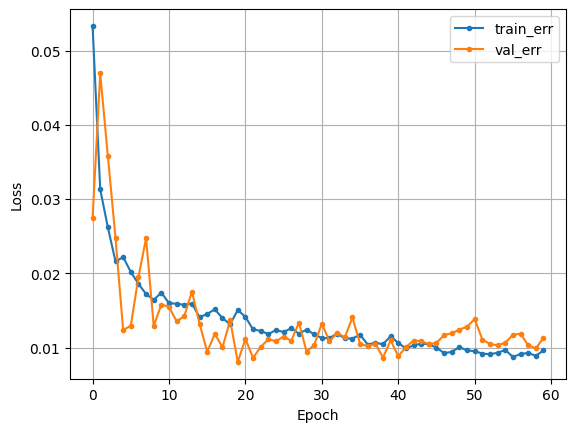

In [34]:
dl_history_plot(history)

### **2) 상품 : 12 - Milk**

* **데이터준비**

* **모델링**

In [38]:
# 제품별 예측 실행
product_ids = [12]
for product_id in product_ids:
    prediction = train_and_predict(df, product_id)
    print(f'Product ID {product_id} 예측 판매량: {prediction.flatten()}')

Epoch 1/100
757/757 [==============================] - 13s 9ms/step - loss: 0.0069
Epoch 2/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0063
Epoch 3/100
757/757 [==============================] - 7s 10ms/step - loss: 0.0061
Epoch 4/100
757/757 [==============================] - 7s 9ms/step - loss: 0.0060
Epoch 5/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0060
Epoch 6/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0060
Epoch 7/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0057
Epoch 8/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0059
Epoch 9/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0058
Epoch 10/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0056
Epoch 11/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0058
Epoch 12/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0055
Epoch 13/10

2/2 [==============================] - 1s 8ms/step
RMSE: 3214.2283774827674
MAE: 1584.9988050130207
MAPE: 0.16242881197306508
R²: 0.10921470948199807
MSE: 10331264.062615503
Product ID 12 예측 판매량: [ 9301.917   8429.035   7791.01    7456.341   8932.094   8144.936
  8723.4375  8400.2295  7338.2393  7713.104   7348.532   8274.226
  9471.483   8638.059   7283.132   8349.878   7350.239   8105.0967
  9185.088   8497.784   8641.401  12087.796  10588.0625  8816.173
 11812.917   8613.769   7687.7803  7518.856   8122.9565 10429.425
  7383.2773  7381.89   11349.174   8126.9844  8611.458   7879.9927
  7124.8696  7535.933  12211.152   8734.63    8820.353   7361.7095
  9451.733   8366.169   9106.254   7821.8545  8666.781   9788.701
 11702.213   7245.6104  7690.9507  7043.469   7828.82    8080.191
  8005.142   7385.9004  7327.5205  8054.034   8051.288   8133.8105]


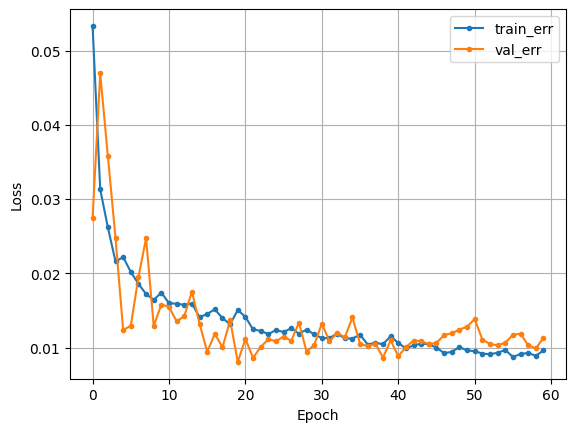

In [39]:
dl_history_plot(history)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

In [40]:
# 제품별 예측 실행
product_ids = [42]
for product_id in product_ids:
    prediction = train_and_predict(df, product_id)
    print(f'Product ID {product_id} 예측 판매량: {prediction.flatten()}')

Epoch 1/100
757/757 [==============================] - 11s 8ms/step - loss: 0.0380
Epoch 2/100
757/757 [==============================] - 6s 7ms/step - loss: 0.0258
Epoch 3/100
757/757 [==============================] - 6s 7ms/step - loss: 0.0241
Epoch 4/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0236
Epoch 5/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0222
Epoch 6/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0208
Epoch 7/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0201
Epoch 8/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0198
Epoch 9/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0187
Epoch 10/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0183
Epoch 11/100
757/757 [==============================] - 6s 8ms/step - loss: 0.0185
Epoch 12/100
757/757 [==============================] - 5s 7ms/step - loss: 0.0171
Epoch 13/100

2/2 [==============================] - 1s 8ms/step
RMSE: 11.794222911266509
MAE: 9.729795455932617
MAPE: 0.09865672934269278
R²: 0.763151156832603
MSE: 139.10369408064386
Product ID 42 예측 판매량: [114.29849   85.621506 118.6962   133.70535   77.43783  157.07202
  89.25459  129.9053   115.76066  133.87447  117.67019  126.8479
  95.56635  127.78805   90.99627   72.03312  144.05644  113.68046
  66.10871  103.773605 142.73265   86.65086   93.911545 146.37079
 132.29243  117.982025 130.341    131.83977   84.867935  97.13069
 100.93805  113.80907  135.12889   81.921814 131.60246  113.109825
  90.18563  124.207886 131.11923  110.59988  109.66296   89.230225
 115.44899   83.089424  96.26125  126.23572   95.38876   70.17673
 119.09081  129.53627   96.28881  109.82471   85.889915 122.23267
  96.79445   88.63103  106.34382  127.08992  106.61844  115.40574 ]


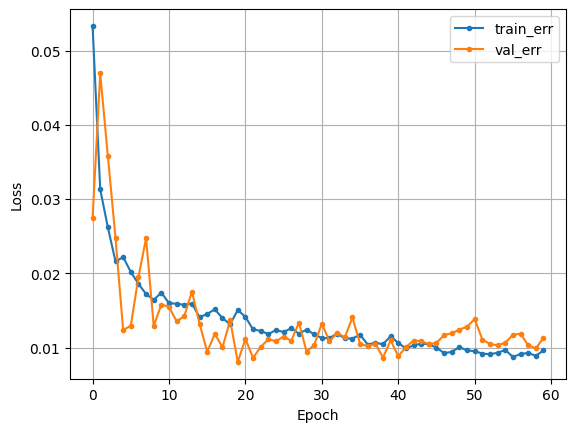

In [42]:
dl_history_plot(history)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

In [44]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# LSTM 모델 훈련 및 예측 함수 수정
def train_and_predict_CNN(df, product_id, test_size=0.2, random_state=None):
    X, Y, scaler_X, scaler_Y = prepare_data(df, product_id)

    # 데이터 분할
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    n_features = X_train.shape[2]

    clear_session()

    model3 = Sequential([
        Conv1D(32, 5, activation='relu', padding='same', input_shape=(X_train.shape[1], n_features)),
        MaxPooling1D(1),
        Conv1D(64, 5, activation='relu', padding='same'),
        MaxPooling1D(1),
        Conv1D(128, 3, activation='relu', padding='same'),
        MaxPooling1D(1),
        Conv1D(256, 3, activation='relu', padding='same'),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])

    # model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')
    model3.compile(optimizer='adam', loss='mean_squared_error')

    # 모델 훈련
    history = model3.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10)]).history

    # 예측 및 예측 값 역정규화
    prediction_scaled = model3.predict(X_test)
    prediction = scaler_Y.inverse_transform(prediction_scaled)

    # 실제 값과 예측 값의 RMSE, MAE, MAPE, R², MSE 계산 및 출력
    Y_test_inv = scaler_Y.inverse_transform(Y_test.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(Y_test_inv, prediction))
    mae = mean_absolute_error(Y_test_inv, prediction)
    mape = mean_absolute_percentage_error(Y_test_inv, prediction)
    r2 = r2_score(Y_test_inv, prediction)
    mse = mean_squared_error(Y_test_inv, prediction)

    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    print(f'R²: {r2}')
    print(f'MSE: {mse}')

    return prediction


In [45]:
# 제품별 예측 실행
product_ids = [3]
for product_id in product_ids:
    prediction = train_and_predict_CNN(df, product_id)
    print(f'Product ID {product_id} 예측 판매량: {prediction.flatten()}')

Epoch 1/100
653/653 [==============================] - 8s 6ms/step - loss: 0.0154
Epoch 2/100
653/653 [==============================] - 4s 5ms/step - loss: 0.0119
Epoch 3/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0103
Epoch 4/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0098
Epoch 5/100
653/653 [==============================] - 3s 5ms/step - loss: 0.0098
Epoch 6/100
653/653 [==============================] - 4s 5ms/step - loss: 0.0093
Epoch 7/100
653/653 [==============================] - 2s 4ms/step - loss: 0.0097
Epoch 8/100
653/653 [==============================] - 2s 4ms/step - loss: 0.0092
Epoch 9/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0096
Epoch 10/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0095
Epoch 11/100
653/653 [==============================] - 2s 4ms/step - loss: 0.0089
Epoch 12/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0093
Epoch 13/100


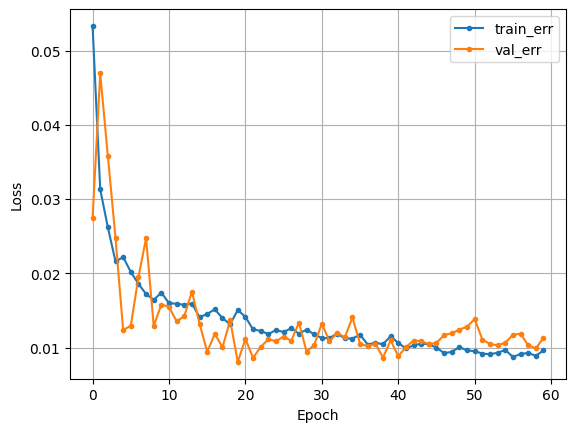

In [46]:
dl_history_plot(history)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

In [47]:
# 제품별 예측 실행
product_ids = [12]
for product_id in product_ids:
    prediction = train_and_predict_CNN(df, product_id)
    print(f'Product ID {product_id} 예측 판매량: {prediction.flatten()}')

Epoch 1/100
653/653 [==============================] - 8s 7ms/step - loss: 0.0086
Epoch 2/100
653/653 [==============================] - 4s 6ms/step - loss: 0.0073
Epoch 3/100
653/653 [==============================] - 4s 6ms/step - loss: 0.0067
Epoch 4/100
653/653 [==============================] - 4s 7ms/step - loss: 0.0069
Epoch 5/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0065
Epoch 6/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0064
Epoch 7/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0065
Epoch 8/100
653/653 [==============================] - 4s 5ms/step - loss: 0.0070
Epoch 9/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0067
Epoch 10/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0065
Epoch 11/100
653/653 [==============================] - 3s 5ms/step - loss: 0.0062
Epoch 12/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0065
Epoch 13/100


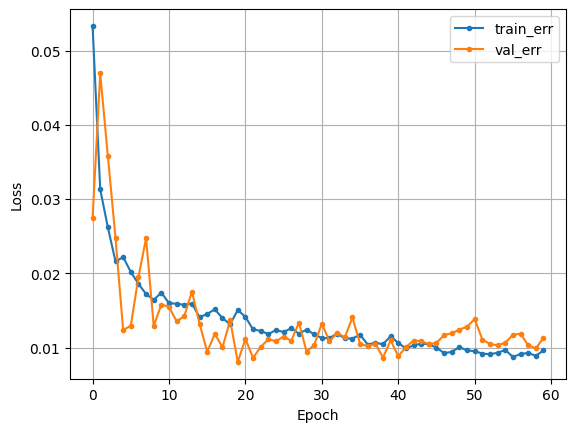

In [48]:
dl_history_plot(history)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

In [49]:
# 제품별 예측 실행
product_ids = [42]
for product_id in product_ids:
    prediction = train_and_predict_CNN(df, product_id)
    print(f'Product ID {product_id} 예측 판매량: {prediction.flatten()}')

Epoch 1/100
653/653 [==============================] - 5s 5ms/step - loss: 0.0407
Epoch 2/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0287
Epoch 3/100
653/653 [==============================] - 2s 4ms/step - loss: 0.0248
Epoch 4/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0236
Epoch 5/100
653/653 [==============================] - 2s 4ms/step - loss: 0.0217
Epoch 6/100
653/653 [==============================] - 6s 9ms/step - loss: 0.0203
Epoch 7/100
653/653 [==============================] - 4s 6ms/step - loss: 0.0193
Epoch 8/100
653/653 [==============================] - 4s 6ms/step - loss: 0.0181
Epoch 9/100
653/653 [==============================] - 6s 9ms/step - loss: 0.0172
Epoch 10/100
653/653 [==============================] - 3s 5ms/step - loss: 0.0148
Epoch 11/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0160
Epoch 12/100
653/653 [==============================] - 3s 4ms/step - loss: 0.0134
Epoch 13/100


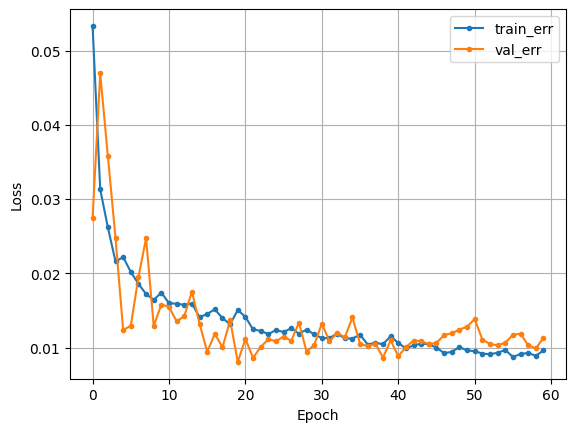

In [51]:
dl_history_plot(history)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [54]:
temp3 = temp.loc[temp['Product_ID'] == 3]
joblib.dump(temp3, 'temp3.pkl')

['temp3.pkl']

In [55]:
temp12 = temp.loc[temp['Product_ID'] == 12]
joblib.dump(temp12, 'temp12.pkl')

['temp12.pkl']

In [56]:
temp42 = temp.loc[temp['Product_ID'] == 42]
joblib.dump(temp42, 'temp42.pkl')

['temp42.pkl']